In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

## "Hello World" in CVX

In [2]:
x = cp.Variable(2)
A = np.array([[2,1],[1,3]])
b = np.array([1,1])
constraints = [A@x >= b,
               x >= 0]

In [3]:
def solve(obj):
    prob = cp.Problem(obj, constraints)
    prob.solve()
    print("status:", prob.status)
    print("optimal value", prob.value)
    print("optimal var", x.value)

In [4]:
obj1 = cp.Minimize(cp.sum(x))
solve(obj1)

status: optimal
optimal value 0.5999999999116253
optimal var [0.4 0.2]


In [5]:
obj2 = cp.Minimize(-cp.sum(x))
solve(obj2)

status: unbounded
optimal value -inf
optimal var None


In [6]:
obj3 = cp.Minimize(x[0])
solve(obj3)

status: optimal
optimal value -2.2491441767693299e-10
optimal var [-2.24914418e-10  1.55371590e+00]


In [7]:
obj4 = cp.Minimize(cp.max(x))
solve(obj4)

status: optimal
optimal value 0.3333333334080862
optimal var [0.33333333 0.33333333]


In [8]:
obj5 = cp.Minimize(x[0]**2 + 9*x[1]**2)
solve(obj5)

status: optimal
optimal value 0.5
optimal var [0.5        0.16666667]


## Heuristic suboptimal solution for Boolean LP

In [9]:
np.random.seed(3)
n = 100
m = 300
A = np.random.rand(m,n)
b = A@np.ones((n,))/2
c = -np.random.rand(n,1)

In [10]:
x = cp.Variable(n)
constraints = [A@x <= b, 0 <= x ,x <= 1]
obj = cp.Minimize(c.T@x)
prob = cp.Problem(obj, constraints)
L = prob.solve()
print("status:", prob.status)
print("optimal value:", prob.value)

status: optimal
optimal value: -34.793048244340724


In [11]:
threshold = np.linspace(0,1,101)
heuri_obj = np.zeros_like(threshold)
maxviol = np.zeros_like(threshold)
for i,t in enumerate(threshold):
    x_hat = x.value>t
    heuri_obj[i] = c.T@x_hat
    maxviol[i] = np.max(A@x_hat - b)

C:\Users\86159\AppData\Local\Temp\ipykernel_9560\2293388272.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  heuri_obj[i] = c.T@x_hat


In [12]:
feasi_mask = maxviol <= 0
infeasi_mask = maxviol > 0
type(feasi_mask)

numpy.ndarray

Text(0, 0.5, 'objective')

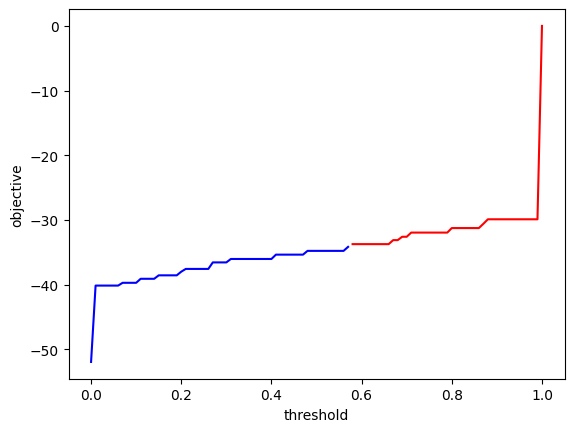

In [13]:
plt.plot(threshold[feasi_mask], heuri_obj[feasi_mask], c = 'r')
plt.plot(threshold[infeasi_mask], heuri_obj[infeasi_mask], c = 'b')
plt.xlabel("threshold")
plt.ylabel("objective")

Text(0, 0.5, 'max violation')

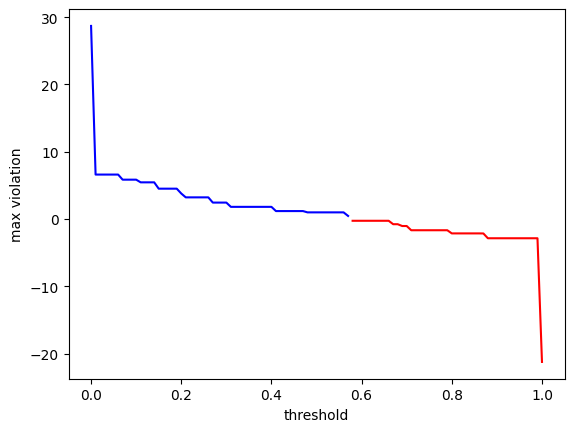

In [14]:
plt.plot(threshold[feasi_mask], maxviol[feasi_mask], c = 'r')
plt.plot(threshold[infeasi_mask], maxviol[infeasi_mask], c = 'b')
plt.xlabel("threshold")
plt.ylabel("max violation")

In [15]:
U = np.min(heuri_obj[feasi_mask])
print("L:",L)
print("U:",U)
U-L

L: -34.793048244340724
U: -33.740088526121


1.052959718219725

## Simple portfolio optimization

In [16]:
np.random.seed(5)
n=20
m=300
S=np.random.rand(n,n)
S = S.T.dot(S)
S = S/np.max(np.abs(np.diag(S)))*.2
S[:,-1] = 0
S[-1,:] = 0
x_unif = np.ones((n,1))/n
pbar = np.ones((n,1))*.03 + np.array(np.append(np.random.rand(n-1,1),0)).reshape((-1,1))*.12

In [17]:
expected_return = np.sum(pbar)/n
x = cp.Variable(n)
constraints1 = [cp.sum(x) == 1, pbar.T@x == expected_return]
constraints2 = constraints1 + [x >= 0]
constraints3 = constraints1 + [cp.sum(cp.pos(-x)) <= 0.5]
obj = cp.Minimize(cp.quad_form(x, S))

#### No (additional constraints) 

In [18]:
prob = cp.Problem(obj, constraints1)
optimal_risk = prob.solve()
optimal_risk

6.593319112952769e-06

#### Long-only : x >=0 

In [19]:
prob = cp.Problem(obj, constraints2)
optimal_risk = prob.solve()
optimal_risk

0.02857662770132503

#### Limit on total short position

In [20]:
prob = cp.Problem(obj, constraints3)
optimal_risk = prob.solve()
optimal_risk

0.002525183950876322

#### risk-return trade-off curves 

d:\anaconda\envs\cvxpy\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


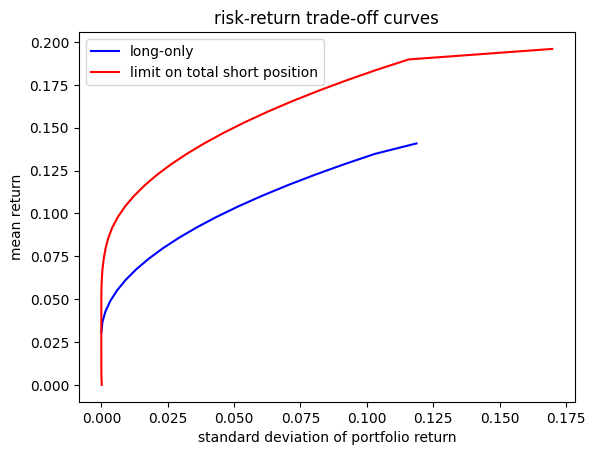

In [21]:
exp_return = np.linspace(0, 0.3, 50)
constraints = [cp.sum(x) == 1]
obj = cp.Minimize(cp.quad_form(x, S))
risk1 = []
risk2 = []
for er in exp_return:
    constr1 = constraints + [pbar.T@x == er, x >= 0]
    constr2 = constraints + [pbar.T@x == er, cp.sum(cp.pos(-x)) <= 0.5]
    prob1 = cp.Problem(obj, constr1)
    risk1 += [prob1.solve()]
    prob2 = cp.Problem(obj, constr2)
    risk2 += [prob2.solve()]

plt.plot(risk1, exp_return, c = 'b', label = 'long-only') 
plt.plot(risk2, exp_return, c = 'r', label = 'limit on total short position')
plt.title("risk-return trade-off curves")
plt.xlabel("standard deviation of portfolio return")
plt.ylabel("mean return")
plt.legend()